In [1]:
import pandas as pd
import geopandas as gpd
import tensorflow as tf
# import teller as tr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
import missingno as msno
# import pyarrow as pa
# import pyarrow.parquet as pq
import numpy as np


In [2]:
# !pip install tensorflow
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno

In [5]:
#1 zrobić dataframe ze współrzędnymi przecięcia okręgów i linii
INPUT_RIVER_BORDER = gpd.read_file('../.inputs/in_out_geojson/out_2022.geojson')
INPUT_STAR = gpd.read_file('../.inputs/lines.geojson')

In [61]:
from shapely import Point
from itertools import chain

def instersekcja(linia_brzegu: gpd.GeoDataFrame, gwiazdka: gpd.GeoDataFrame, starting_point: Point, epsg: str)-> list :
    """
    calculate list with distances from starting point to intersecting point
    :param linia_brzegu: geopandas geodataframe  - jest okodowana transformacja jednak lepiej żeby dane były w 2178
    :param gwiazdka: geopandas geodataframe
    :param starting_point: dict
    :param epsg: str docelowe epsg
    :return: list
    """
    linia_brzegu.to_crs(crs=epsg, inplace=True)
    line_geometry = linia_brzegu.iloc[0].geometry #wyciaganie wspolrzednych

    return [
        gw_row.geometry.intersection(line_geometry) if isinstance(gw_row.geometry.intersection(line_geometry), Point) else gw_row.geometry.intersection(line_geometry).geoms[0]
        for gw_row in gwiazdka.itertuples()
        if not gw_row.geometry.intersection(line_geometry).is_empty]


df_p = instersekcja(linia_brzegu=INPUT_RIVER_BORDER, gwiazdka=INPUT_STAR, starting_point=Point(7527541.11, 5863838.87),epsg= 'EPSG:2178' )

In [67]:
df_p = gpd.GeoDataFrame(geometry=df_p)
df_p

ValueError: Must pass array with one dimension only.

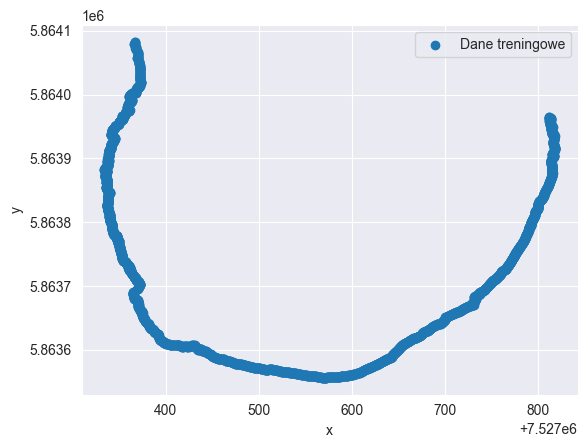

In [71]:
# Wyświetlenie danych i dopasowania modelu
plt.scatter(df_p.geometry.get_coordinates().x, df_p.geometry.get_coordinates().y, label='Dane treningowe')
# plt.plot(x_test, y_pred, 'r-', label='Dopasowanie modelu')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

82/82 [==============================] - 0s 1ms/step


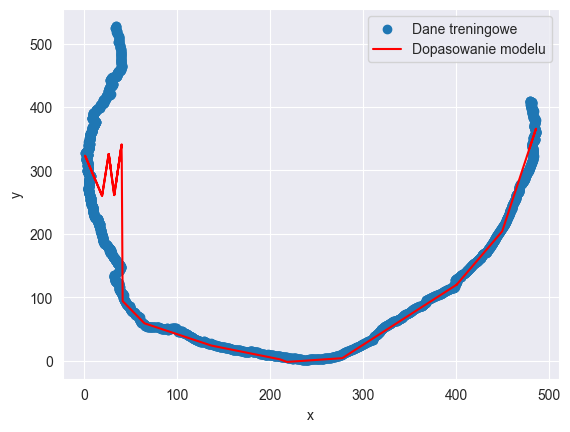

In [90]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Tworzenie danych x i y, przy założeniu zależności wielomianowej 10. stopnia
x_train = df_p.geometry.get_coordinates().x
x_train = x_train - x_train.min()+1
y_train = df_p.geometry.get_coordinates().y
y_train = y_train- y_train.min()+1

# Definicja modelu sieci neuronowej z wielomianem 10. stopnia
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(1,), activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Kompilacja modelu
model.compile(optimizer='adam', loss='mse')

# Trenowanie modelu
model.fit(x_train, y_train, epochs=10000, verbose=0)

# Przewidywanie wartości y dla danych x

y_pred = model.predict(x_train)

# Wyświetlenie danych i dopasowania modelu
plt.scatter(x_train, y_train, label='Dane treningowe')
plt.plot(x_train, y_pred, 'r-', label='Dopasowanie modelu')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()